<a href="https://colab.research.google.com/github/Francis-Valcke/Burgie2_DL_GA2/blob/master/GA2_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second graded assignment - analysis of model quality


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

#!ls '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.datasets import cifar100

# load train and test data
(x_train, r_train_class), (x_test, r_test_class) = cifar100.load_data(label_mode='coarse')

# some preprocessing ... convert integers to floating point and rescale them to [0,1] range
x_test = x_test.astype('float32')
x_test /= 255

print(x_test.shape[0], ' original test samples')

# Numebr of test samples
N_test = x_test.shape[0]

r_test = keras.utils.to_categorical(r_test_class)

# look at the new labels for the firs sample
print(r_test[0])

num_classes = 20

10000  original test samples
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


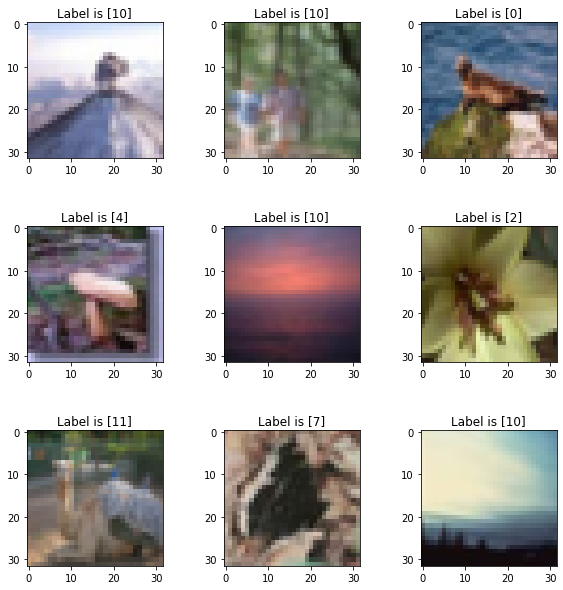

In [ ]:
f = plt.figure(figsize=(10,10));
for idx in range(9):
    plt.subplot(3,3,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label is " + str(r_test_class[idx]))
    plt.imshow(np.reshape(x_test[idx,:],(32,32,3)), cmap='Greys', interpolation='None')

## Load model and run it on the test data



In [ ]:
# fill in the path of the model you want to evaluate here
modelpath="/content/gdrive/My Drive/Colab Notebooks/DL2021/GA2/model_0.1.h5"
tested_model=tf.keras.models.load_model(modelpath)
predictions = tested_model.predict(x_test)

test_predicted_class = np.argmax(predictions,axis=1)
r_test_new = r_test_class.ravel()
misclassified = np.where(test_predicted_class != r_test_new)[0]
print("There are ",misclassified.shape[0]," misclassified samples in the test set.")


There are  4824  misclassified samples in the test set.


Our scoring measure is accuracy, but it is often useful to look at the performance of the model for individual classes. The measures commonly used in this case are called *precision*, *recall* and *F1-score* (definitions can be found [here](https://en.wikipedia.org/wiki/Confusion_matrix) ).

Below, we use an sklearn function to calculate these measures.

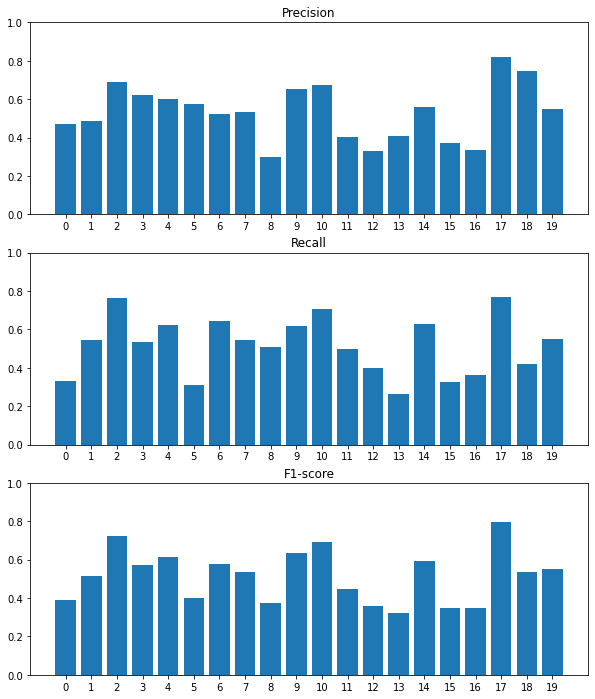

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, f1, _ = score(r_test_new, test_predicted_class)

names = ['0','1','2','3','4','5','6','7','8','9', '10','11','12','13','14','15','16','17','18','19']
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.bar(names, precision)
plt.ylim([0.0,1])
plt.title("Precision")
plt.subplot(3,1,2)
plt.bar(names, recall)
plt.title("Recall")
plt.ylim([0.0,1])
plt.subplot(3,1,3)
plt.bar(names, f1)
plt.ylim([0.0,1])
plt.title("F1-score")
plt.show()

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(f1))

## Visualise errors

We can go further and find some of the misclassified examples about which the model is most certain:


In [ ]:
def plot_image(predictions, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions),
                                true_label),
                                color=color)


# this function shows the predictions for this sample
def plot_value_array(predictions, true_label):
  plt.grid(False)
  plt.xticks(range(20))
  plt.yticks([])
  thisplot = plt.bar(range(20), predictions, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

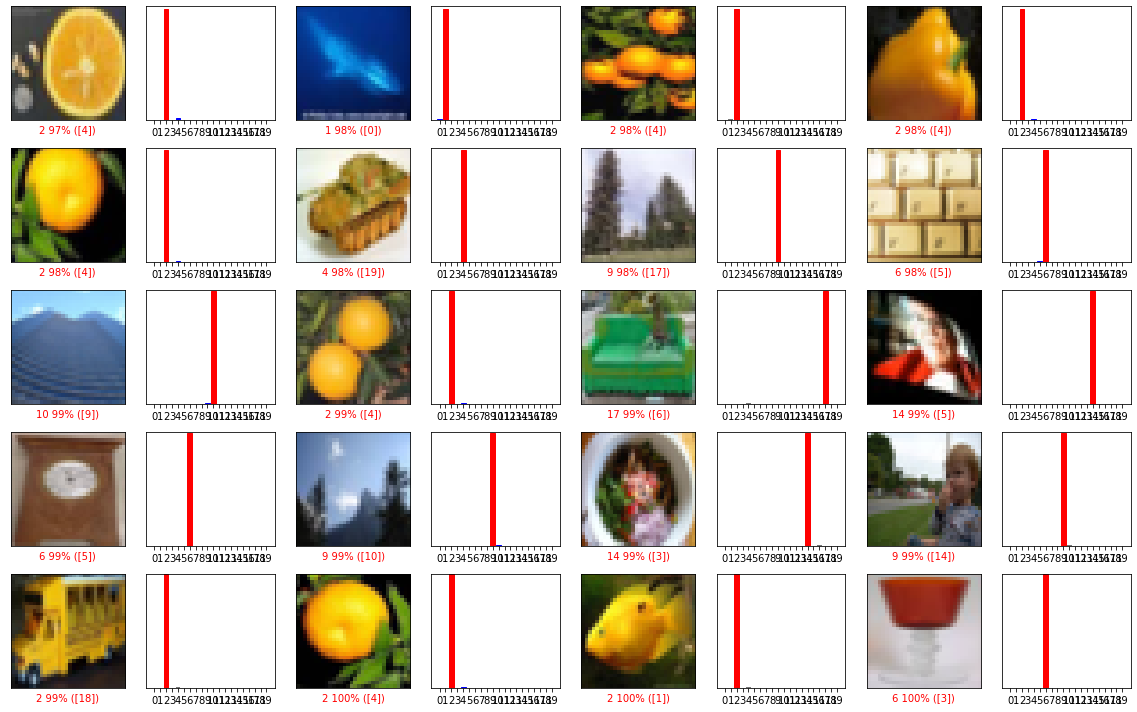

In [ ]:
maxprob = np.max(predictions, axis=1)

most_certain = np.argsort(maxprob[misclassified])
most_certain = misclassified[most_certain[-20:]]

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  idx=most_certain[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(predictions[idx], r_test_class[idx], np.reshape(x_test[idx],(32,32, 3)))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(predictions[idx], r_test_new[idx])
plt.tight_layout()
plt.show()

## Plotting confusion matrices

You can use the function defined below to plot a confusion matrix. This shows how often each class is confused with each other class.

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
    if len(classes) == 0:
        num_classes = max(len(np.unique(true_labels)),len(np.unique(predictions)))
        classes = range(num_classes)
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()



Confusion matrix, without normalization


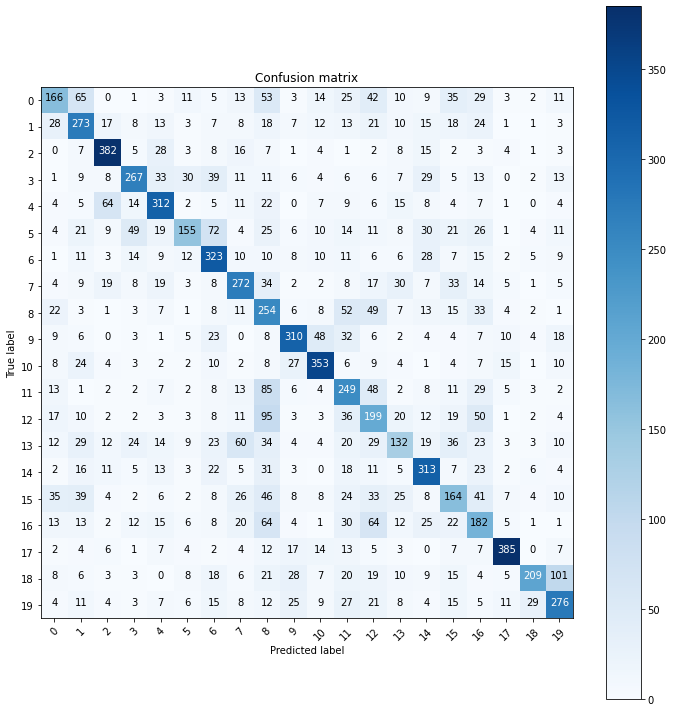

In [ ]:
plot_confusion_matrix(r_test_new, test_predicted_class)

Normalized confusion matrix


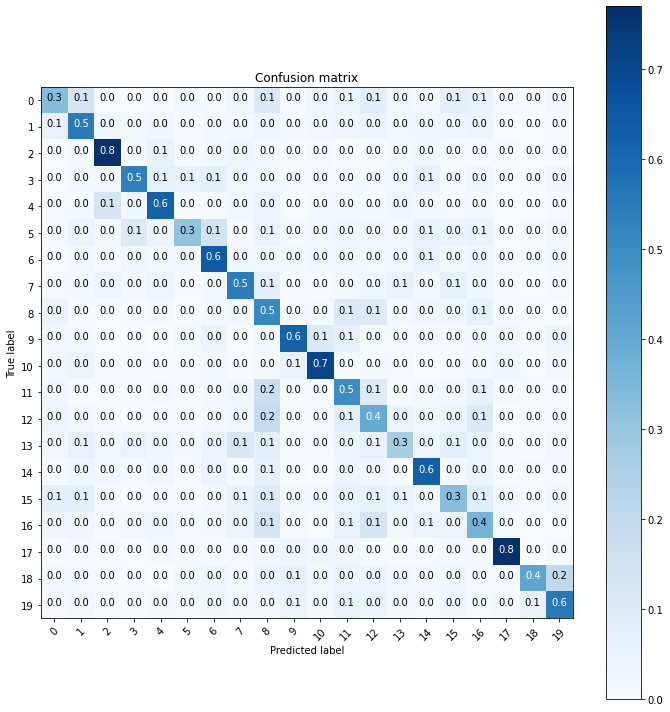

In [ ]:
plot_confusion_matrix(r_test_new, test_predicted_class, normalize=True)